<a href="https://colab.research.google.com/github/arpan-das-astrophysics/LangChain-Vector-Databases-in-Production-Activeloop/blob/main/Creating_Knowledge_Graphs_from_Textual_Data_Unveiling_Hidden_Connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating Knowledge Graphs from Textual Data: Unveiling Hidden Connections**

## **Introduction**
In today's data-driven world, understanding the relationships between different pieces of information is crucial. Knowledge graphs have emerged as a powerful way to visualize and explore these connections, transforming unstructured text into a structured network of entities and their relationships. We will guide you through a simple workflow for creating a knowledge graph from textual data, making complex information more accessible and easier to understand.

### **Workflow for Creating Knowledge Graphs from Textual Data**
Here’s what we are going to do in this project.

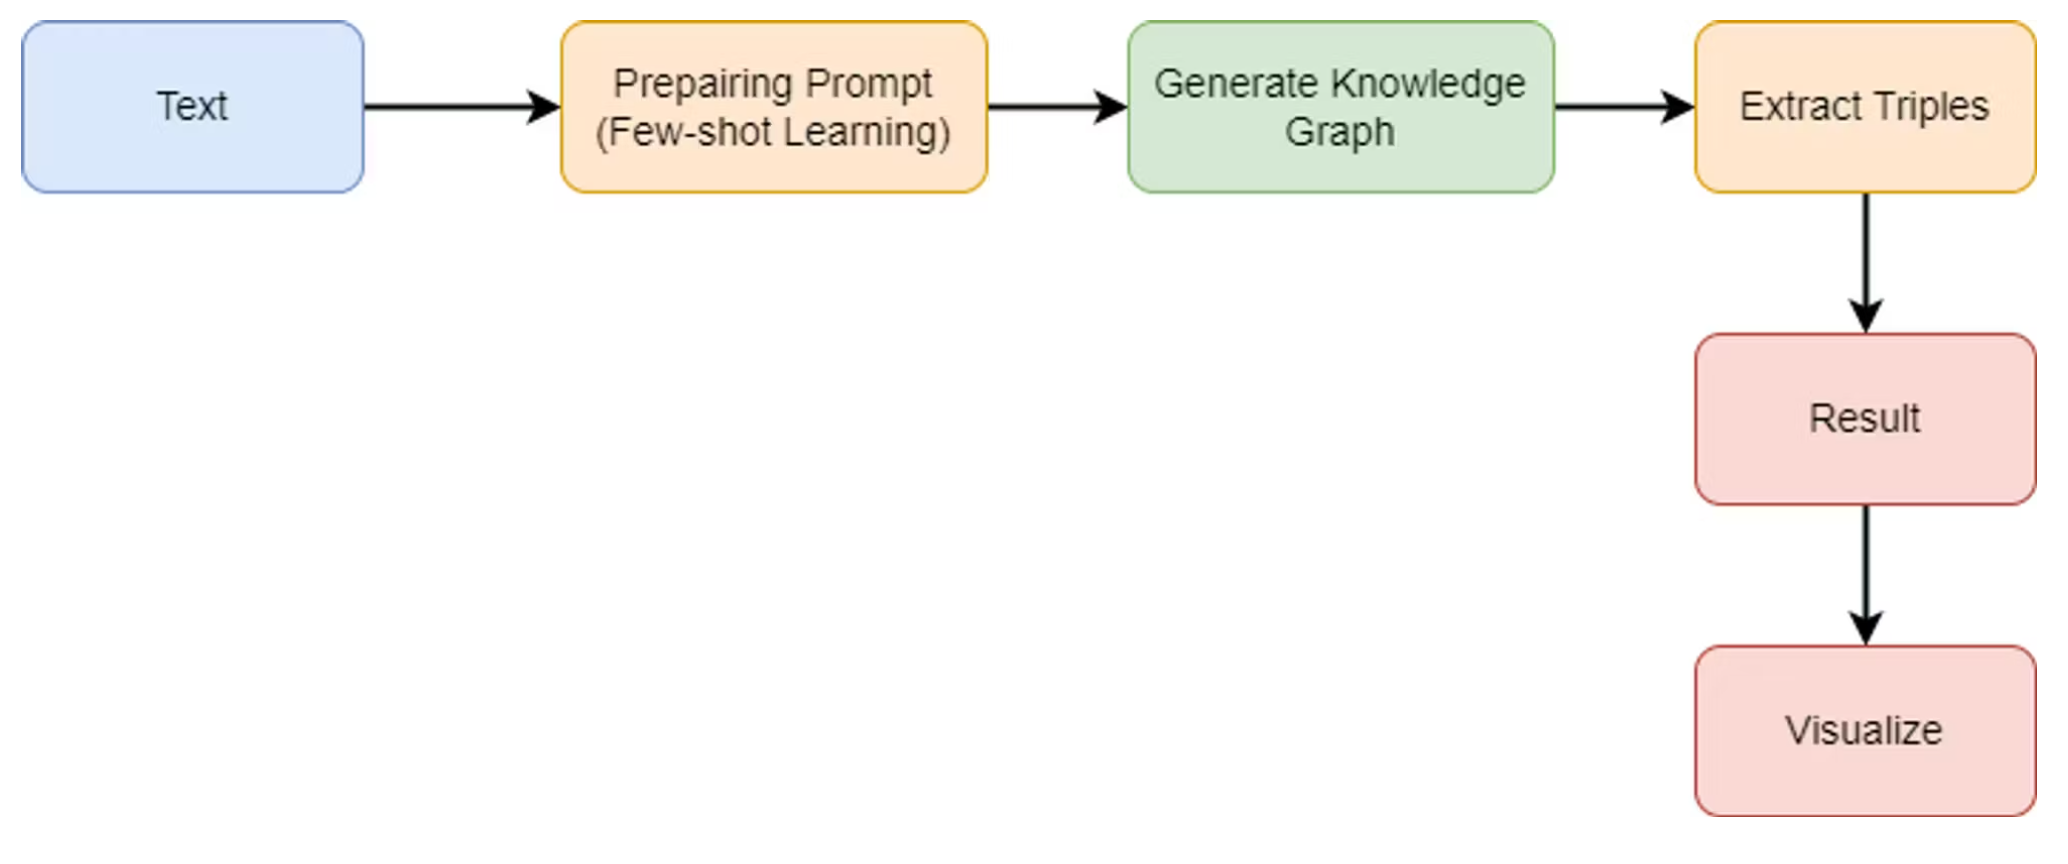

### **Knowledge Graphs and Knowledge Bases: know the difference.**
Before diving deep into our main topic, it's important to have a clear understanding of the difference between Knowledge Graphs and Knowledge Bases.

The terms "knowledge graph" and "knowledge base" are often used interchangeably, but they have subtle differences. Knowledge base (KB) refers to structured information that we have about a domain of interest. On the other hand, a knowledge graph is a knowledge base structured as a graph, where nodes represent entities and edges signify relations between those entities. For example, from the text “Fabio lives in Italy,” we can extract the relation triplet <Fabio, lives in, Italy>, where “Fabio” and “Italy” are entities, and “lives in” it’s their relation.

A knowledge graph is a particular type of knowledge base. A knowledge base is not necessarily a knowledge graph.

### **Building a Knowledge Graph**
The process of building a knowledge graph usually consists of two sequential steps:

1. **Named Entity Recognition (NER):** This step involves extracting entities from the text, which will eventually become the nodes of the knowledge graph.
2. **Relation Classification (RC):** In this step, relations between entities are extracted, forming the edges of the knowledge graph.
Then, the knowledge graph is commonly visualized using libraries such as pyvis .

Typically the process of creating a knowledge base from the text can be enhanced by incorporating additional steps, such as:

* Entity Linking: This involves normalizing entities to the same entity, such as “Napoleon” and “Napoleon Bonapart.” This is usually done by linking them to a canonical source, like a Wikipedia page.
* Source Tracking: Keeping track of the origin of each relation, such as the article URL and text span. Keeping track of the sources allows us to gather insights into the reliability of the extracted information (e.g., a relation is accurate if it can be extracted from several sources considered accurate).

In this project, we’ll do the Named Entity Recognition and Relation Classification tasks simultaneously with an appropriate prompt. This joint task is commonly called Relation Extraction (RE).

In [1]:
!pip install -q langchain==0.0.208 openai python-dotenv pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


In [2]:
from getpass import getpass
import os
os.environ["OPENAI_API_KEY"] = getpass()

··········


### **Building a Knowledge Graph with LangChain**
To demonstrate an example of using a prompt to extract relations from the text in LangChain, we can use the following  `KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT` prompt as a starting point. This prompt is designed to extract knowledge triples (subject, predicate, and object) from a given text input.

This prompt can be used by the `ConversationEntityMemory` class from LangChain library, which is a way for chatbots to keep a memory of the past messages of a conversation by storing the relations extracted from the past messages. Memory classes will be explained in a later lesson. In this example, we use this prompt just to extract relations from texts without leveraging a memory class.

Let's understand the structure of the `KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT.` This prompt is an instance of the `PromptTemplate` class with the input variable text. The template is a string that provides a few shot examples and instructions for the language model to follow when extracting knowledge triples from the input text.

In [3]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain.graphs.networkx_graph import KG_TRIPLE_DELIMITER

# Prompt template for knowledge triple extraction
_DEFAULT_KNOWLEDGE_TRIPLE_EXTRACTION_TEMPLATE = (
    "You are a networked intelligence helping a human track knowledge triples"
    " about all relevant people, things, concepts, etc. and integrating"
    " them with your knowledge stored within your weights"
    " as well as that stored in a knowledge graph."
    " Extract all of the knowledge triples from the text."
    " A knowledge triple is a clause that contains a subject, a predicate,"
    " and an object. The subject is the entity being described,"
    " the predicate is the property of the subject that is being"
    " described, and the object is the value of the property.\n\n"
    "EXAMPLE\n"
    "It's a state in the US. It's also the number 1 producer of gold in the US.\n\n"
    f"Output: (Nevada, is a, state){KG_TRIPLE_DELIMITER}(Nevada, is in, US)"
    f"{KG_TRIPLE_DELIMITER}(Nevada, is the number 1 producer of, gold)\n"
    "END OF EXAMPLE\n\n"
    "EXAMPLE\n"
    "I'm going to the store.\n\n"
    "Output: NONE\n"
    "END OF EXAMPLE\n\n"
    "EXAMPLE\n"
    "Oh huh. I know Descartes likes to drive antique scooters and play the mandolin.\n"
    f"Output: (Descartes, likes to drive, antique scooters){KG_TRIPLE_DELIMITER}(Descartes, plays, mandolin)\n"
    "END OF EXAMPLE\n\n"
    "EXAMPLE\n"
    "{text}"
    "Output:"
)

KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT = PromptTemplate(
    input_variables=["text"],
    template=_DEFAULT_KNOWLEDGE_TRIPLE_EXTRACTION_TEMPLATE,
)

# Instantiate the OpenAI model
llm = OpenAI(model_name="text-davinci-003", temperature=0.9)

# Create an LLMChain using the knowledge triple extraction prompt
chain = LLMChain(llm=llm, prompt=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT)

# Run the chain with the specified text
text = "The city of Paris is the capital and most populous city of France. The Eiffel Tower is a famous landmark in Paris."
triples = chain.run(text)

print(triples)

 (Paris, is the capital, France)<|>(Paris, is a, city)<|>(Paris, is the most populous city, France)<|>(Eiffel Tower, is a, landmark)<|>(Eiffel Tower, is in, Paris)
END OF EXAMPLE


In the previous code, we used the prompt to extract relation triplets from text using few-shot examples. We'll then parse the generated triplets and collect them into a list.

Here, triples_response will contain the knowledge triplets extracted from the text. We need to parse the response and collect the triplets into a list:

In [4]:
def parse_triples(response, delimiter=KG_TRIPLE_DELIMITER):
    if not response:
        return []
    return response.split(delimiter)

triples_list = parse_triples(triples)

# Print the extracted relation triplets
print(triples_list)

[' (Paris, is the capital, France)', '(Paris, is a, city)', '(Paris, is the most populous city, France)', '(Eiffel Tower, is a, landmark)', '(Eiffel Tower, is in, Paris)\nEND OF EXAMPLE']


### **Knowledge Graph Visualization**
The NetworkX library is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. It provides various graph generators, random graphs, and synthetic networks, along with the benefits of Python's fast prototyping, ease of teaching, and multi-platform support.

To visualize the extracted triplets as a knowledge graph, we’ll be using the pyvis library; To install the library, execute the following command. While it is preferable to install the latest version of the packages, it is worth noting that the codes in this lesson were written using version 0.3.2.

In [9]:
from pyvis.network import Network
import networkx as nx

# Create a NetworkX graph from the extracted relation triplets
def create_graph_from_triplets(triplets):
    G = nx.DiGraph()
    for triplet in triplets:
        subject, predicate, obj = triplet.strip().split(',')
        G.add_edge(subject.strip(), obj.strip(), label=predicate.strip())
    return G

# Convert the NetworkX graph to a PyVis network
def nx_to_pyvis(networkx_graph):
    pyvis_graph = Network(notebook=True, cdn_resources='remote')
    for node in networkx_graph.nodes():
        pyvis_graph.add_node(node)
    for edge in networkx_graph.edges(data=True):
        pyvis_graph.add_edge(edge[0], edge[1], label=edge[2]["label"])
    return pyvis_graph

triplets = [t.strip() for t in triples_list if t.strip()]
graph = create_graph_from_triplets(triplets)
pyvis_network = nx_to_pyvis(graph)

# Customize the appearance of the graph
pyvis_network.toggle_hide_edges_on_drag(True)
pyvis_network.toggle_physics(False)
pyvis_network.set_edge_smooth('discrete')

# Show the interactive knowledge graph visualization
pyvis_network.show("knowledge_graph.html")

knowledge_graph.html


First, we defined two functions for creating and visualizing a knowledge graph from a list of relation triplets; then, we used the triples_list to create a list of cleaned triplets which creates a NetworkX graph and converts it to a PyVis network. It also customizes the graph's appearance by enabling edge hiding on drag, disabling physics, and setting edge smoothing to 'discrete.’

With that process, we generated an interactive HTML file named knowledge_graph.html containing the knowledge graph visualization based on the extracted relation triplets:

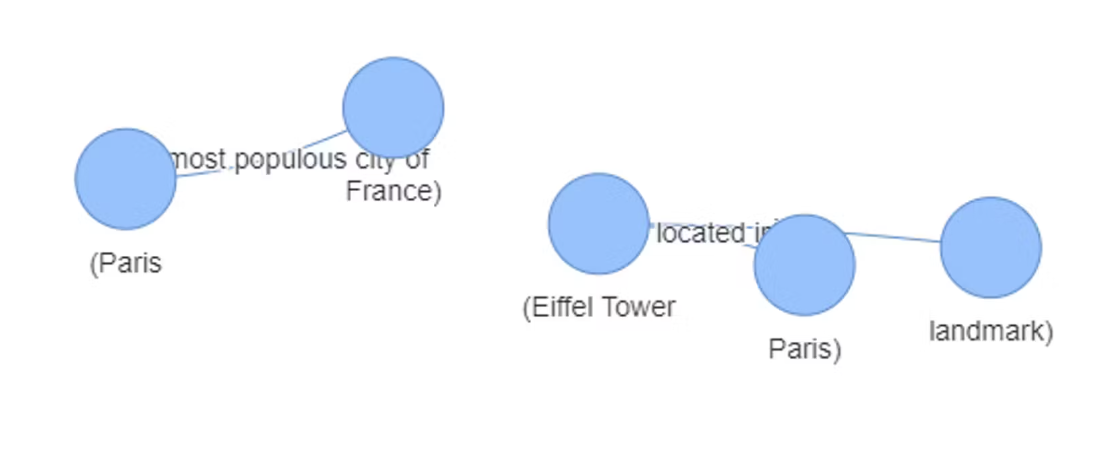

## **Conclusion**
Throughout this article, we've demonstrated a straightforward yet powerful workflow for creating knowledge graphs from textual data. We've transformed unstructured text into a structured network of entities and their relationships, making complex information more accessible and easier to understand.

It's worth noting that LangChain offers the GraphIndexCreator class, which automates the extraction of relation triplets and is seamlessly integrated with question-answering chains. In future articles, we'll delve deeper into this powerful feature, showcasing its potential further to enhance your knowledge graph creation and analysis capabilities.

The knowledge graph created through this workflow serves as a valuable tool for visualizing complex relationships and opens the door for further analysis, pattern recognition, and data-driven decision-making.